Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring [DONE]
- write code to get osm amenity data based on category

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- density of shops [DONE]
- isochrone from geocoded point

Step 1: Import packages

In [69]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import networkx as nx

Step 2: Generate buffer around location of interest

In [70]:
# Set name for Nominatim query
query = "Masinag"
buffer_dist = 1_500

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

c:\Users\HOWARD\miniconda3\envs\ccims\Lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


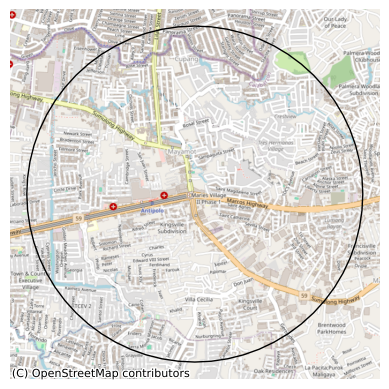

In [71]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

Step 3: Extract street network within buffer then pre-process

In [72]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [73]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [74]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([4, 1, 2, 3, 6, 5])

In [75]:
streets.head()

osmid  lanes  ref              name  \
u        v          key                                             
25353079 2001383000 0       4243609      4   59  Sumulong Highway   
         485547459  0       4243609      4   59  Sumulong Highway   
         1908173877 0    1013993994      1  NaN     Alexander III   
25353172 7348802645 0       4243609      4   59  Sumulong Highway   
         7755219331 0       4243609      4   59  Sumulong Highway   

                             highway maxspeed width  oneway reversed  length  \
u        v          key                                                        
25353079 2001383000 0        primary       50  13.2   False     True  29.567   
         485547459  0        primary       50  13.2   False    False  59.142   
         1908173877 0    residential      NaN   NaN   False     True  86.135   
25353172 7348802645 0        primary       50  13.2   False    False  16.624   
         7755219331 0        primary       50  13.2   False     True   6.273   

                                                                  geometry  \
u        v          key                                                      
25353079 2001383000 0    LINESTRING (13483562.513 1645845.693, 13483549...   
         485547459  0    LINESTRING (13483562.513 1645845.693, 13483574...   
         1908173877 0    LINESTRING (13483562.513 1645845.693, 13483548...   
25353172 7348802645 0    LINESTRING (13484238.790 1645265.119, 13484254...   
         7755219331 0    LINESTRING (13484238.790 1645265.119, 13484232...   

                          access bridge junction service tunnel  
u        v          key                                          
25353079 2001383000 0        NaN    NaN      NaN     NaN    NaN  
         485547459  0        NaN    NaN      NaN     NaN    NaN  
         1908173877 0    private    NaN      NaN     NaN    NaN  
25353172 7348802645 0        NaN    NaN      NaN     NaN    NaN  
         7755219331 0        NaN    NaN      NaN     NaN    NaN

Step 4: Plotting the street network and intersection heatmap

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


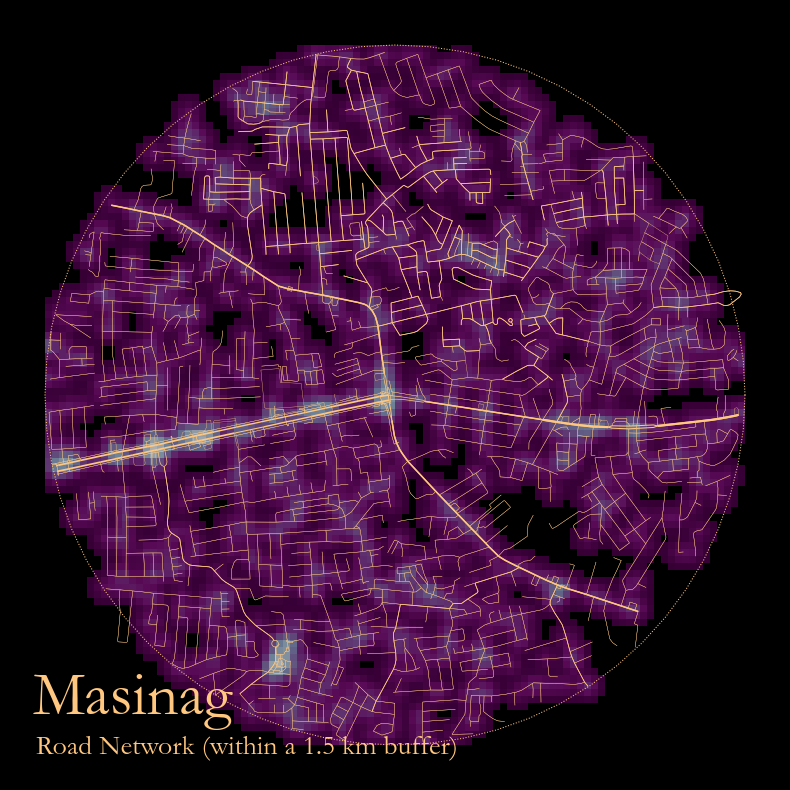

In [76]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

plot_heatmap(
    intersections,
    "street_count",
    ax=ax,
    alpha=0.7,
    color_scheme="BuPu_r",
    bounds=ring_bounds
)

Part B: Generating a heatmap for other POIs

Step 1: Extract shops within buffer

In [77]:
# Extract all shops within the buffer
shop_pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
    }
)

# Examine number of rows and columns
shop_pois.shape

(140, 50)

Step 2: Clean up shop data

In [78]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
shop_pois = drop_nan_cols(shop_pois, 0.75)

In [79]:
# Examine # of rows & cols after pre-processing
shop_pois.shape

(140, 4)

In [80]:
# Flatten column indices
# (this should be in the function)
shop_pois = shop_pois.reset_index()

shop_pois.head()

,element_type,osmid,addr:province,name,shop,geometry
0,node,696289106,Rizal,Ugat Furniture Factory,furniture,POINT (121.11236 14.62271)
1,node,696289249,Rizal,PF Trading,hardware,POINT (121.11285 14.62282)
2,node,696289272,Rizal,Searton Marketing Corp,hardware,POINT (121.11317 14.62331)
3,node,696289304,Rizal,Manila Water,utilities,POINT (121.11517 14.62278)
4,node,696289308,Rizal,Rey Home Center,hardware,POINT (121.11473 14.62273)


In [81]:
# Assign weight to all shops (for heatmap)
shop_pois["weight"] = 1.0

In [82]:
# Reproject to Pseudo-Mercator
shop_pois = shop_pois.to_crs("EPSG:3857")

In [83]:
# Set feature geometries as their centroids
# (this should be in the function)
shop_pois["geometry"] = shop_pois["geometry"].centroid
shop_pois.shape

(140, 7)

Step 3: Plot shop density heatmap

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


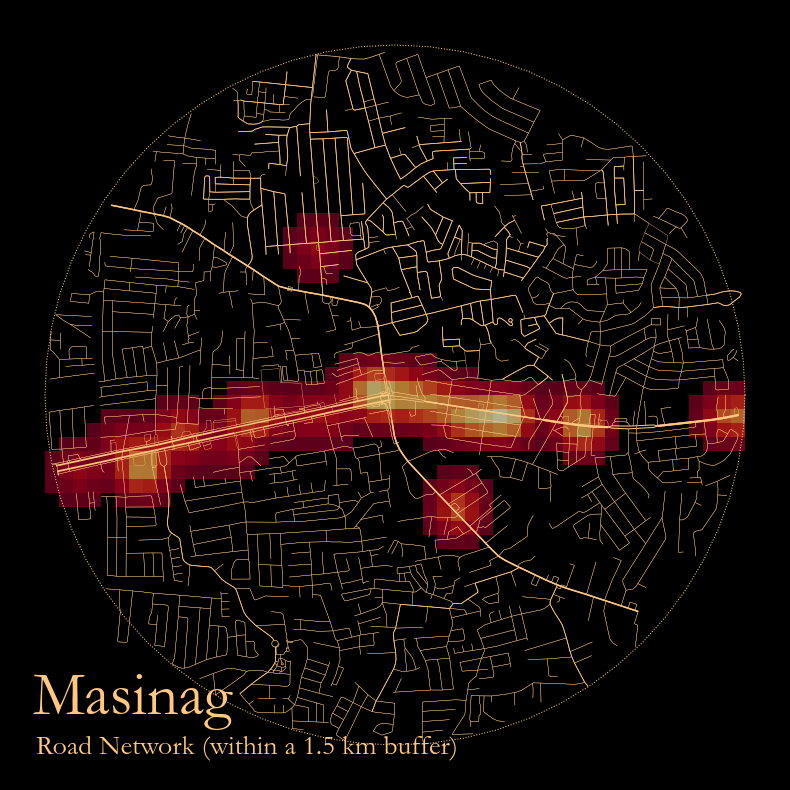

In [84]:
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

plot_heatmap(
    shop_pois,
    "weight",
    bins=50,
    ax=ax,
    alpha=0.7,
    color_scheme="YlOrRd_r",
    bounds=ring_bounds
)

Part C: Visualizing betweenness centrality of street intersections

Step 1: Calculate betweenness centrality per node

In [96]:
bc = nx.betweenness_centrality(graph, weight="street_count")

Step 2: Join betweenness values to each node via osmid

In [97]:
nx.set_node_attributes(graph, bc, "bc")

Step 3: Convert graph to GDFS, then preprocess

In [98]:
intersections, streets = ox.graph_to_gdfs(graph)

In [99]:
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [100]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([4, 1, 2, 3, 6, 5])

In [101]:
# Multiply by 1,000 (since function calculates log of heatmap)
intersections["bc_1k"] = intersections["bc"] * 1_000

Step 4: Plot betweenness centrality!

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


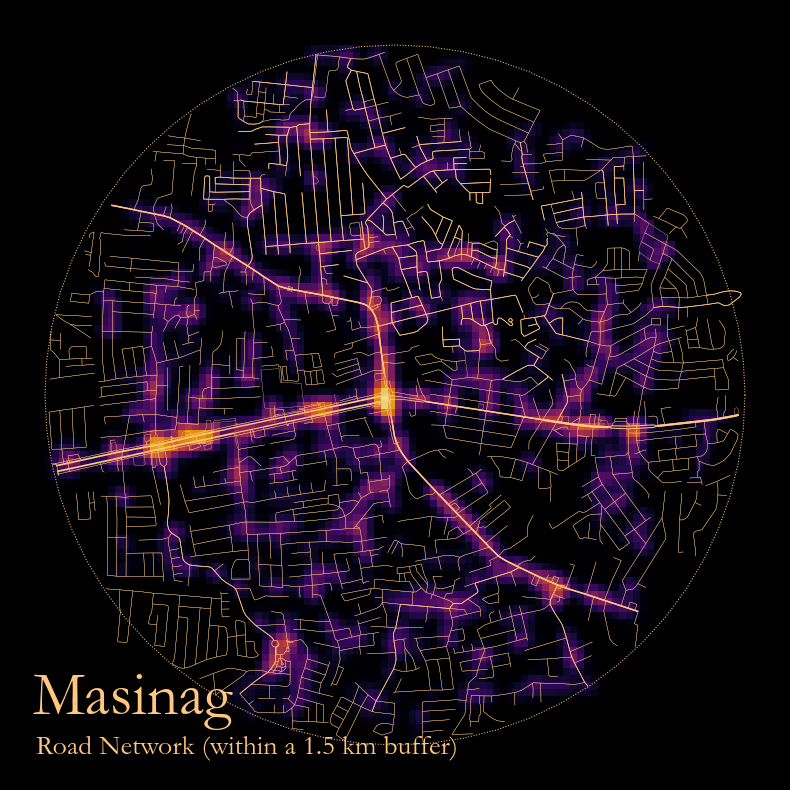

In [109]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# Plot heatmap of betweenness centrality
plot_heatmap(
    intersections,
    "bc_1k",
    ax=ax,
    alpha=0.9,
    color_scheme="inferno",
    bounds=ring_bounds
)